<a href="https://colab.research.google.com/github/rusonariga/young-modulus-calculator/blob/main/Young_modulus_calculator_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h1 align="center"><i>Young's modulus calculation</i></h1>

This notebook will be used to calculate the Young module from different samples meassured in laboratory.

$$\sigma = E \Delta l$$

where $\sigma = F/A$

##<h2>Importing libraries</h2>

In [ ]:
# Import libraries
from google.colab import files
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.stats import describe
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

##<h2>Setting the notebook</h2>


###<h3>Create folders</h3> 
Before start running the script, go to left bar and inside <code>content</code> create 2 folders with the following names:
<ul><li>data</li><li>results</li>

or run the following cell

In [ ]:
!pwd

if os.path.exists('data'):
  if os.path.exists('results'):
    if os.path.exists('figures'):
      print("Set up ready to upload files")
    else:
      !mkdir figures
  else:
    !mkdir results figures
else:
  !mkdir data results figures

/content
Set up ready to upload files


###<h3>Upload data</h3>
Upload datasets to <code>content/data</code> folder

In [ ]:
%cd data/
files.upload()
%cd ..
!pwd

/content/data


Saving VG_T_ISO_25_0 to VG_T_ISO_25_0 (1)
/content
/content


###<h3>Data import from uploaded files</h3>

In [ ]:
# Manual upload file and read
folder = "/content/data/"
# file = "VG_T_ASTM_60_30"
file = "VG_T_ISO_25_0"

data = pd.read_csv(folder+file,delim_whitespace=True,header=None)
# modify following definition depending the input dataset
data.columns = ["EXTENSION [mm]", "TIME [s]", "LOAD [kgf]", "CALIBRATED WIDTH [mm]", 
                "CALIBRATED HEIGHT [mm]","CALIBRATED LENGTH [mm]"]

In [ ]:
# We extract data
width = data["CALIBRATED WIDTH [mm]"][0]      # In mm
height = data["CALIBRATED HEIGHT [mm]"][0]    # In mm
l0 = data["CALIBRATED LENGTH [mm]"][0]        # in mm

# We extract the length and load, last 2 values are discarded 
l = data["EXTENSION [mm]"].to_numpy()[:-2]             # stroke displacement In mm
F = data["LOAD [kgf]"].to_numpy()[:-2]                  # applied load In kgf


In [ ]:
# We convert from these units to SI units
mm2m = 1e-3
kgf2N = 9.81
Pa2MPa = 1e-6
MPa2GPa = 1e-3 

# gage geometry conversion
width = width*mm2m
height = height*mm2m
l0 = l0*mm2m 

# test measurements conversion
l = l*mm2m              # l in m
F = F*kgf2N             # F in N

We compute the stress as:

$\sigma = \frac{F}{w\times h}$

In [ ]:
# We compute sigma

stress = F/(width*height)

# We conver stress to MPa

stress = stress*Pa2MPa

We compute the strain as:

$ strain = \frac{l}{l_0}$


In [ ]:
strain = l/l0        

## <h2> Plots of test dataset </h2>

Here we plot raw data as received from measurements, units converted to SI

###<h3> F vs. l </h3>
Stroke load vs stroke displacement 

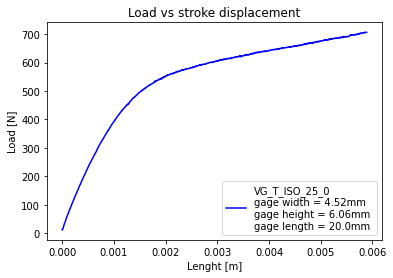

In [ ]:
label = file + '\ngage width = {}mm \ngage height = {}mm \ngage length = {}mm' \
        .format(data["CALIBRATED WIDTH [mm]"][0],
                data["CALIBRATED HEIGHT [mm]"][0],
                data["CALIBRATED LENGTH [mm]"][0])
plt.plot(l,F,label= label,color='b')
plt.xlabel("Lenght [m]")
plt.ylabel("Load [N]")

plt.legend()
plt.title('Load vs stroke displacement')
plt.show()

###<h3>Plot for $\sigma$ vs. $strain$</h3>

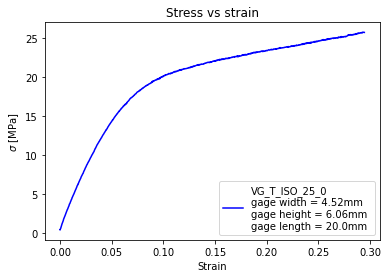

In [ ]:
label = file + '\ngage width = {}mm \ngage height = {}mm \ngage length = {}mm' \
        .format(data["CALIBRATED WIDTH [mm]"][0],
                data["CALIBRATED HEIGHT [mm]"][0],
                data["CALIBRATED LENGTH [mm]"][0])
plt.plot(strain,stress,label=label,color='b')
plt.xlabel("Strain")
plt.ylabel("$\sigma$ [MPa]")
plt.legend()
plt.title('Stress vs strain')
plt.show()

##<h2> Proportional stress zone</h2>

In order to calculate the proportional stress ($\sigma_p$) withing the range of values of thresh, an upper and lower value are given in function of proportion to the maximum stress ($\sigma_{max}$). Recommended values are 30 and 50.

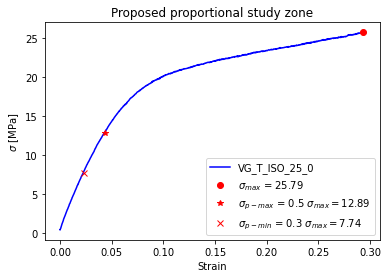

In [ ]:
stress_prop_lim_low = 30                                   # lower % position of proportionality stress to max stress
stress_prop_lim_upp = 50                                   # upper % position of proportionality stress to max stress

stress_max = stress.max()
strain_stress_max = np.mean(strain[stress == stress_max])

stress_prop_low = stress_max * stress_prop_lim_low/100
strain_stress_prop_low = np.min(strain[stress>stress_prop_low])

stress_prop_upp = stress_max * stress_prop_lim_upp/100
strain_stress_prop_upp = np.min(strain[stress>stress_prop_upp])

plt.plot(strain,stress,label=file,color='b')
plt.plot(strain_stress_max,stress_max,"o",color='r',label=r'$\sigma_{max}$ = 'f'{stress_max:0.2f}')
plt.plot(strain_stress_prop_upp,stress_prop_upp ,"*",color='r',
         label=r'$\sigma_{p-max}$ = 'f'{stress_prop_lim_upp/100} 'r'$\sigma_{max}= $'f'{stress_prop_upp:0.2f}')
plt.plot(strain_stress_prop_low,stress_prop_low,"x",color='r',
         label=r'$\sigma_{p-min}$ = 'f'{stress_prop_lim_low/100} 'r'$\sigma_{max}= $'f'{stress_prop_low:0.2f}')
plt.xlabel("Strain")
plt.ylabel(r"$\sigma$ [MPa]")
plt.title('Proposed proportional study zone')
plt.legend(loc=4)
plt.show()


In [ ]:
strain_stress_max

0.293375

## <h2>Correlation coefficient analisis</h2>

We define the correlation coefficient between $\sigma$ and $l$ as

$$corr(s,l) = \frac{\int_0^L (s - \hat s) (l - \hat l) dx}{\sqrt{\sigma_s^2 \sigma_l^2}} $$

where $\hat A$ means average value in the range.

This will define a variable called <code>corr</code> that measures how values from the test deviates from a linear behavior.

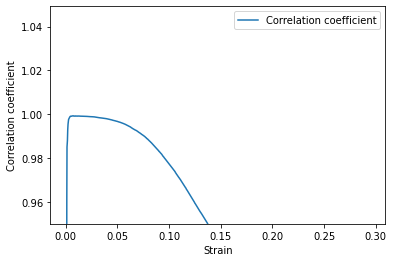

In [ ]:
corr = []
for N in range(0,strain.size):
    corr.append(np.corrcoef(strain[0:N],stress[0:N])[0,1])

corr = np.array(corr)

plt.plot(strain,corr, label="Correlation coefficient")
plt.xlabel("Strain")
plt.ylabel(r"Correlation coefficient")
plt.ylim(bottom=0.95)
plt.legend()
plt.show()

We impose a criteria: `thresh`. This is a constant that works as bottom line from where correlation coeffiecients greater than it (and so on test data associated to them) are considered to follow an acceptable linear behavior.

As seen, the accepted values ($ \sigma_p$ $area$) are the one that also are included into the proportional zone.

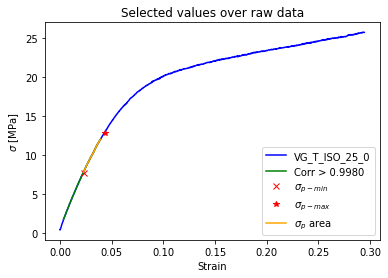

0.9999999999999998


In [ ]:
# change this value depending on the provided data
thresh = 0.998
valid = corr >= thresh              #assigns all the corr values greater than thresh

strain_corr = strain[valid]        # kept extension values that fits selected thresh 
stress_corr = stress[valid]        # kept tension values that fits selected thresh 


# We select stress values within the limits
stress_valid = stress_corr[(stress_corr <= stress_prop_upp) &
                            (stress_corr >= stress_prop_low)] 

# We select strain values within the limits
strain_valid = strain_corr[(stress_corr <= stress_prop_upp) &
                            (stress_corr >= stress_prop_low)] 


plt.plot(strain,stress,label=file,color='b')
plt.plot(strain_corr,stress_corr,color='g',label= f"Corr > {thresh:0.4f}")
plt.plot(strain_stress_prop_low,stress_prop_low,"x",color='r',
         label=r'$\sigma_{p-min}$')
plt.plot(strain_stress_prop_upp,stress_prop_upp ,"*",color='r',
         label=r'$\sigma_{p-max}$')
plt.plot(strain_valid,stress_valid,color='orange',label=r'$\sigma_{p}$ area')
plt.xlabel("Strain")
plt.ylabel(r"$\sigma$ [MPa]")
plt.title('Selected values over raw data')
plt.legend(loc=4)
plt.show()

# We validate linear correlation
print(np.corrcoef(strain_valid, strain_valid)[0,1])

## <h2>Young modulus and Yield Stress calculation</h2>

Standard requires Young's modulus should be calculated between $\sigma_{80}$ and  $\sigma_{85}$, the values of sigma for the 80% and 85% of the proportional stress.

User should define the target ($\sigma_{t}$) within the mentioned range.

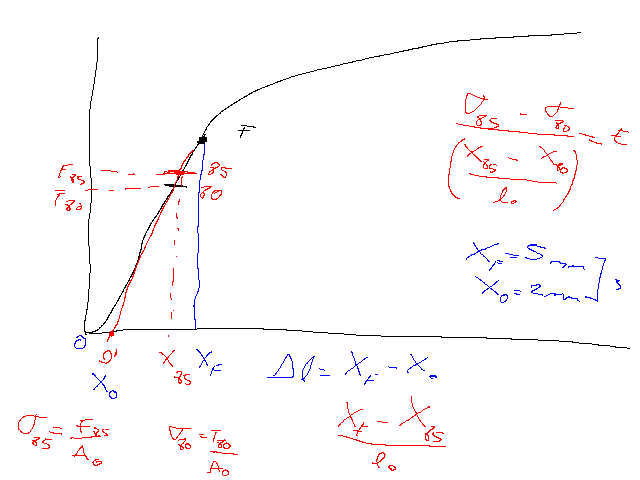

In [ ]:
# we extract the desired values
stress_yield0 = np.max(stress_valid)                           # yield stress based on the thresh values

strain_stress_yield0 = np.max(strain_valid)                            # strain of yield stress based on the thresh values

c_t = 82.5/100                                           # stress target coefficient (70 - 85)

strain_t = strain_stress_yield0 * c_t                                         # extension related to the calculated target stress

# Select extension values in the neightbour of selected yield stress
l_upper = 5/100                                       # upper bound of extension values (min: 2.5 / max:10)
l_lower = 5/100                                      # lower bound of extension values (min: 2.5 / max:10)

strain_t_u = strain_stress_yield0*(c_t+l_upper)                            # upper extension value related to target stress
strain_t_l = strain_stress_yield0*(c_t-l_lower)                            # lower extension value related to target stress

s_t = np.interp(strain_t, strain_valid, stress_valid)          # target stresses
s_ltu = np.interp(strain_t_u, strain_valid, stress_valid)  
s_ltl = np.interp(strain_t_l, strain_valid, stress_valid) 

Select values between both desired limits and find the equation of a line based on linear regression

In [ ]:
select = [(strain_valid > strain_t_l) * (strain_valid < strain_t_u)][0]

# We find the best fit to these values
fit = linregress(strain_valid[select], stress_valid[select])  # linear regresion to find sl0pe,etc.
print(fit)

LinregressResult(slope=256.8935291583026, intercept=2.0873656346808254, rvalue=0.9959398861590638, pvalue=8.629796081222542e-12, stderr=7.342819850658113)


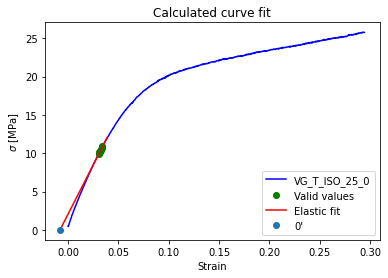

In [ ]:
# We find the crossing point for the x axis of the new linear equation
E_zero = -fit[1]/fit[0]

# Values of new linear equation to plot
Eplot = np.array([E_zero, strain_stress_yield0])

# plt.figure(figsize=(10, 8))
plt.plot(strain,stress, label=file, color ='b')
plt.plot(strain_valid[select],stress_valid[select], "o",label=f"Valid values",color='g')
plt.plot(Eplot, fit[0]*Eplot+fit[1], label="Elastic fit",color='r')
plt.plot(E_zero, 0, "o",label="0'")
plt.xlabel("Strain")
plt.ylabel(r"$\sigma$ [MPa]")
plt.title("Calculated curve fit")
plt.legend(loc=4)
plt.show()

###<h3>Young's modulus calculation</h3>

2.562e-01 GPa
0.25622520175927205 GPa


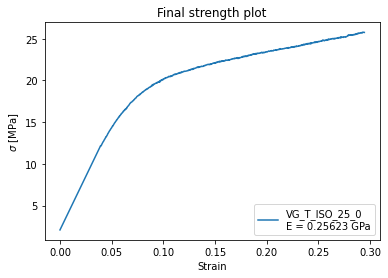

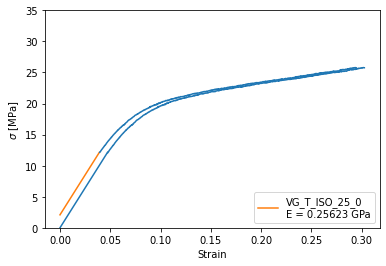

In [ ]:
# We redefine the distance from the 0' found above
x_ltu = strain_t_u - E_zero
x_ltl = strain_t_l - E_zero

# We compute E
E = (s_ltu - s_ltl)/(x_ltu- x_ltl) * MPa2GPa
print(f"{E:0.3e} GPa")
print(f"{E} GPa")

plastic_l = strain[strain>strain_stress_yield0]
plastic_s = stress[strain>strain_stress_yield0]
elastic_l = strain[strain<=strain_stress_yield0]
elastic_s = fit[0]*elastic_l+fit[1]

# plt.figure(figsize=(10, 8))
plt.plot(elastic_l,elastic_s,label = file + f"\nE = {E:0.5f} GPa")
plt.gca().set_prop_cycle(None)
plt.plot(plastic_l,plastic_s)
plt.title("Final strength plot")
plt.legend(loc=4)
plt.xlabel("Strain")
plt.ylabel(r'$\sigma$ [MPa]')
plt.show()


plastic_l1 = strain[strain>=strain_stress_yield0]+fit[1]/fit[0]
plastic_s1 = stress[strain>=strain_stress_yield0]
elastic_l1 = np.array([0, plastic_l1.min()])
elastic_s1 = fit[0]*elastic_l1 


test= np.array([0,0.15])
yield_stress = fit[0]*test- 0.002*fit[0]      # set a parallel line placed 0.2% of strain


plt.plot(elastic_l1,elastic_s1)
plt.gca().set_prop_cycle(None)
plt.plot(plastic_l1,plastic_s1)
plt.plot(elastic_l,elastic_s,label = file + f"\nE = {E:0.5f} GPa")
plt.gca().set_prop_cycle(None)
plt.plot(plastic_l,plastic_s)
plt.xlabel("Strain")
plt.ylabel(r"$\sigma$ [MPa]")
plt.ylim(bottom=0, top= 35)
plt.legend(loc=4)

###<h3>Yield Stress calculation</h3>

Based on standards for non-linear materials, final yield stress is determined by the interception of a parallel line to the elastic region located at 0.2% of the origin and the test dataset.

Sigma yield = 14.1871 [MPa] 
E = 0.2562 [GPa]
rm: cannot remove 'data/*': No such file or directory
/content


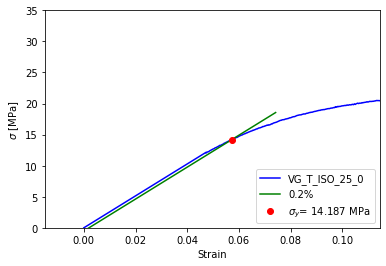

In [ ]:
plastic_l = np.copy(strain[strain>=strain_stress_yield0])+fit[1]/fit[0]
plastic_s = np.copy(stress[strain>=strain_stress_yield0])
elastic_l = np.array([0, plastic_l.min()])
elastic_s = fit[0]*elastic_l 

strain_tmp = np.concatenate((elastic_l, plastic_l))
stress_tmp = np.concatenate((elastic_s, plastic_s))

dif = stress_tmp - (fit[0]*strain_tmp- 0.002*fit[0])
Imin = []
for i in range(len(dif)-2):
  if dif[i]*dif[i+1] < 0:
    Imin.append(i)
val = min(Imin)

# ******  We compute Sigma_y  ********************
strain_stress_yield = strain_tmp[val]
stress_yield = fit[0]*strain_stress_yield- 0.002*fit[0]      


# ******  We compute Sigma_max  ********************  
stress_max = np.max(stress_tmp)
strain_stress_max = np.max(strain_tmp[stress_tmp == stress_max])

print(f"Sigma yield = {stress_yield:0.4f} [MPa] \nE = {E:0.4f} [GPa]")

# Cleaning data folder
%rm -r data/*
!pwd

# plt.figure(figsize=(10, 8))
plt.plot(strain_tmp,stress_tmp,label=file,color='b')
plt.plot(strain_tmp[strain_tmp<strain_stress_yield*1.3],
         fit[0]*strain_tmp[strain_tmp<strain_stress_yield*1.3]- 0.002*fit[0],
         label="0.2%",color='g') # set a parallel line placed 0.2% of strain
plt.plot(strain_stress_yield,stress_yield ,"o",color='r',label=r'$\sigma_{y}$'+ f"= {stress_yield :0.3f} MPa")
plt.xlabel("Strain")
plt.ylabel(r"$\sigma$ [MPa]")
plt.ylim(bottom=0, top= 35)
plt.xlim(right= strain_stress_yield*2)
plt.legend(loc=4)

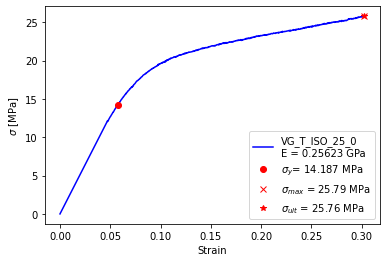

In [ ]:
  # plot result
  plt.plot(strain_tmp,stress_tmp,color='b',label=file + f"\nE = {E:0.5f} GPa")
  plt.plot(strain_stress_yield,stress_yield ,"o",color='r',label=r'$\sigma_{y}$'+ f"= {stress_yield :0.3f} MPa")
  plt.plot(strain_stress_max,stress_max,"x",color='r',label=r'$\sigma_{max}$ = 'f'{stress_max:0.2f} MPa')
  plt.plot(strain_tmp[-1],stress_tmp[-1],"*",color='r',label=r'$\sigma_{ult}$ = 'f'{stress_tmp[-1]:0.2f} MPa')
  plt.xlabel("Strain") 
  plt.ylabel(r"$\sigma$ [MPa]")
  plt.legend(loc=4)

  

#<h1>Updating dataframe and saving</h1>

Calculated information is appended to the original dataset and saved as "csv" into <code>results</code> .

In [ ]:
# Create dataframe of results
results_columns=["EXTENSION [m]","LOAD [kgf]","STRESS [MPa]","STRAIN","CALIBRATED WIDTH [mm]",
                 "CALIBRATED HEIGHT [mm]","CALIBRATED LENGTH [mm]","E [GPa]","YIELD STRAIN",
                 "YIELD STRESS [MPa]","ULTIMATE STRESS [MPa]"]
results = pd.DataFrame(np.nan, index = np.arange(len(l)), columns=results_columns)

s = pd.Series(stress_tmp)
s1 = pd.Series(s, index=results.index)
st = pd.Series(strain_tmp)
st1 = pd.Series(st, index=results.index)

results["EXTENSION [m]"] = l
results["LOAD [kgf]"] = F
results["STRESS [MPa]"] = s1
results["STRAIN"] = st1
results["CALIBRATED WIDTH [mm]"][0] = width
results["CALIBRATED HEIGHT [mm]"][0] = height 
results["CALIBRATED LENGTH [mm]"][0] = l0
results["E [GPa]"][0] = E
results["YIELD STRAIN"][0] = strain_stress_yield
results["YIELD STRESS [MPa]"][0] = stress_yield
results["ULTIMATE STRESS [MPa]"][0] = stress_max
print(results)

# Saving results into CSV
%cd results/
results.to_csv(file+".csv")
%cd ..

     EXTENSION [m]  LOAD [kgf]  ...  YIELD STRESS [MPa]  ULTIMATE STRESS [MPa]
0         0.000000   12.847196  ...           14.187051              25.785009
1         0.000000   12.533845  ...                 NaN                    NaN
2         0.000000   12.220503  ...                 NaN                    NaN
3         0.000002   12.847196  ...                 NaN                    NaN
4         0.000002   12.220503  ...                 NaN                    NaN
..             ...         ...  ...                 ...                    ...
951       0.005864  706.282349  ...                 NaN                    NaN
952       0.005870  706.282349  ...                 NaN                    NaN
953       0.005876  706.282349  ...                 NaN                    NaN
954       0.005882  705.655608  ...                 NaN                    NaN
955       0.005888  705.655608  ...                 NaN                    NaN

[956 rows x 11 columns]
/content/results
/content


In [ ]:
# Cleaning data folder
%rm -r data/*

rm: cannot remove 'data/*': No such file or directory


In [ ]:
!pwd
# %cd ..

/content


In [ ]:
%rm -r data/*
%rm -r figures/*
%rm -r results/*

rm: cannot remove 'data/*': No such file or directory
rm: cannot remove 'figures/*': No such file or directory
